<a href="https://colab.research.google.com/github/Gnkhakimova/CS5590-Cyber/blob/master/Membership_Attack_solution_guidelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# required imports
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  


import torch
import torchvision 
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [48]:
# mount the google drive to download the datasets
from google.colab import drive
drive.mount('/content/drive')
project_path = '~/.pytorch/CIFAR_data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# create transforms to load the images, nothing much is needed here. 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [50]:
# download CIFAR 10 training set
trainset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=True,
                                        download=True, transform=transform_train)

# load the trainning set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# download the test data
testset = torchvision.datasets.CIFAR10(root= project_path+'/data', train=False,
                                        download=True, transform=transform_test)

# load the test data
testloader =torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# check those manually on the dataset site: https://www.cs.toronto.edu/~kriz/cifar.html 

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat plane   cat horse


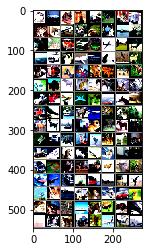

In [5]:
# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs, labels = iter(trainloader).next()
imshow(torchvision.utils.make_grid(imgs)) 

# notice who we converted the class idx to labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# run this cell multiple times and notice diff images

In [6]:
# divide the training dataset into the required groups Make sure they are balanced
# original trainset is made of 50k images

total_size = len(trainset)
split1 = total_size // 4
split2 = split1 * 2
split3 = split1 * 3

print(total_size, split1, split2, split3)

indices = list(range(total_size))

# two groups to train the shadow (in and out)
shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]

# two groups to train the Target (in and out)
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]

50000 12500 25000 37500


In [0]:
batch_size = 128 # pick your own

# divide and load shadow train in and out
shadow_train_sampler = SubsetRandomSampler(shadow_train_idx) # Pytorch function
shadow_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_train_sampler)

shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
shadow_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=shadow_out_sampler)

# divide and load Target in and out
target_train_sampler = SubsetRandomSampler(target_train_idx) # Pytorch function
target_out_sampler = SubsetRandomSampler(target_out_idx) # Pytorch function

target_train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_train_sampler)
target_out_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=target_out_sampler)


In [0]:
# create a CNN
# Input shape (3, 32, 32) 
# architecture: simple. 2 conv and 2 Max pool, followed by 2 fc (120, 84) 
# output of fc is 10 because we have 10 classes!



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # inut channel = 3 RGB, out channels = 6, kernel = 5
        self.pool = nn.MaxPool2d(2,2) # kernel size = 2, stride = 2
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# initalize a target model and train it

target_model = Net()
criterion = nn.CrossEntropyLoss()# CrossEntropyLoss
optimizer = optim.Adam(target_model.parameters(), lr=0.001)# try Adam VS SGD

# let the magic begin
for epoch in range(20):  

    running_loss = 0.0
    
    for i, data in enumerate(target_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = target_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # make a prediction: forward prop
        
        # calculate the loss
        
        # calculate gradients
        
        # updaate weights in backprop

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0     
        

print('Finished Training the Target model...')

Finished Training the Target model...


In [10]:
# calculate the accuracy of the Target Model
correct = 0
total = 0

with torch.no_grad():
    for data in target_out_loader:
        images, labels = data
        outputs = target_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %




---



In [11]:
# initalize a Shadow Model and Train it
# for the first ICP, your shadow model can have the same CNN architecture and hyperparameters

shadow_model = target_model
shadow_criterion = nn.CrossEntropyLoss()
shadow_optimizer = optim.Adam(target_model.parameters(), lr=0.001)

# let the magic begin
for epoch in range(1):  

    running_loss = 0.0
    
    for i, data in enumerate(shadow_train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = shadow_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # make a prediction: forward prop
        
        # calculate the loss
        
        # calculate gradients
        
        # updaate weights in backprop

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0     


print('Finished Training the Shadow model')

Finished Training the Shadow model


In [12]:
# freeze the Shadow model 
# make predictions on both datasets (shadow_in and shdow_out)
# create a new dataset of the shape [predictions(shadow_in), 1], [predicitons(shadow_out), 1] and zip them together


correct = 0
total = 0

with torch.no_grad():
    for data in shadow_out_loader:
        images, labels = data
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 50 %


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in shadow_train_loader:
        images, labels = data
        outputs = shadow_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [0]:
lr = 0.01
k = 3

In [0]:
def weights_init(m): 
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear): 
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias, 0)

In [0]:
class attack_net(nn.Module): 
    def __init__(self, n_in=3, n_out=1, n_hidden=64): 
        super(attack_net, self).__init__()
        
        self.hidden = nn.Linear(n_in, n_hidden)
        #self.bn = nn.BatchNorm1d(n_hidden)
        self.output = nn.Linear(n_hidden, n_out)
        
    def forward(self, x): 
        x = F.sigmoid(self.hidden(x))
        #x = self.bn(x)
        out = self.output(x)
        #out = F.sigmoid(self.output(x))
        
        return out

In [0]:
def train(net, data_loader, test_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    losses = []
    for epoch in range(n_epochs):
        net.train()
        for i, batch in enumerate(data_loader):

            imgs, labels = batch
            imgs, labels = imgs, labels

            optimizer.zero_grad()

            outputs = net(imgs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))
        print("Training:")
        train_accuracy = eval_target_net(net, data_loader, classes=classes)
        print("Test:")
        test_accuracy = eval_target_net(net, test_loader, classes=classes)
        #plt.plot(losses)
        #plt.show()
    return train_accuracy, test_accuracy
        
def train_attacker(attack_net, shadow, shadow_train, shadow_out, optimizer, criterion, n_epochs, k):
    
    """
    Trains attack model (classifies a sample as in or out of training set) using
    shadow model outputs (probabilities for sample class predictions). 
    The type of shadow model used can vary.
    """
        
    in_predicts=[]
    out_predicts=[]
    losses = []
    
    if type(shadow) is not Pipeline:
        shadow_net=shadow
        shadow_net.eval()

    for epoch in range(n_epochs):
       
        total = 0
        correct = 0

        #train_top = np.array([])
        #train_top = []
        train_top = np.empty((0,2))
        out_top = np.empty((0,2))
        for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(shadow_train, shadow_out)):

            if train_imgs.shape[0] != out_imgs.shape[0]: 
                break
                
            #######out_imgs = torch.randn(out_imgs.shape)
            mini_batch_size = train_imgs.shape[0]
            
            if type(shadow) is not Pipeline:
                train_imgs, out_imgs = train_imgs, out_imgs

                train_posteriors = F.softmax(shadow_net(train_imgs.detach()), dim=1)
                
                out_posteriors = F.softmax(shadow_net(out_imgs.detach()), dim=1)

                
            else:
                traininputs= train_imgs.view(train_imgs.shape[0],-1)
                outinputs=out_imgs.view(out_imgs.shape[0], -1)
                
                in_preds=shadow.predict_proba(traininputs)
                train_posteriors=torch.from_numpy(in_preds).float()
                #for p in in_preds:
                 #   in_predicts.append(p.max())
                
                out_preds=shadow.predict_proba(outinputs)
                out_posteriors=torch.from_numpy(out_preds).float()
                #for p in out_preds:
                 #   out_predicts.append(p.max())
                            

            train_sort, _ = torch.sort(train_posteriors, descending=True)
            train_top_k = train_sort[:,:k].clone()
            for p in train_top_k:
                in_predicts.append((p.max()).item())
            out_sort, _ = torch.sort(out_posteriors, descending=True)
            out_top_k = out_sort[:,:k].clone()
            for p in out_top_k:
                out_predicts.append((p.max()).item())

            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))


            train_lbl = torch.ones(mini_batch_size)
            out_lbl = torch.zeros(mini_batch_size)

            optimizer.zero_grad()

            train_predictions = torch.squeeze(attack_net(train_top_k))
            out_predictions = torch.squeeze(attack_net(out_top_k))

            loss_train = criterion(train_predictions, train_lbl)
            loss_out = criterion(out_predictions, out_lbl)

            loss = (loss_train + loss_out) / 2
            
            if type(shadow) is not Pipeline:
                loss.backward()
                optimizer.step()

            
            correct += (F.sigmoid(train_predictions)>=0.5).sum().item()
            correct += (F.sigmoid(out_predictions)<0.5).sum().item()
            total += train_predictions.size(0) + out_predictions.size(0)


            print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))
            
        #Plot distributions for target predictions in training set and out of training set
        """
        fig, ax = plt.subplots(2,1)
        plt.subplot(2,1,1)
        plt.hist(in_predicts, bins='auto')
        plt.title('In')
        plt.subplot(2,1,2)
        plt.hist(out_predicts, bins='auto')
        plt.title('Out')
        """

        '''
        plt.scatter(out_top.T[0,:], out_top.T[1,:], c='b')
        plt.scatter(train_top.T[0,:], train_top.T[1,:], c='r')
        plt.show()
        '''

In [0]:
# create the Attack Model: A NN binary classifier {0, 1}
# the input to this model is the propability distribution vector of size 10
# and the output is either 0 (input was not included in training) or 1
attack_net = attack_net(n_in=k)
attack_net.apply(weights_init)

attack_loss = nn.BCEWithLogitsLoss()
#attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)


In [0]:
from sklearn.pipeline import Pipeline

In [44]:
train_attacker(attack_net, shadow_model, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, n_epochs=2, k=k)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/2][0/98] loss = 0.74, accuracy = 50.00
[0/2][1/98] loss = 0.70, accuracy = 50.00
[0/2][2/98] loss = 0.69, accuracy = 50.00
[0/2][3/98] loss = 0.71, accuracy = 50.00
[0/2][4/98] loss = 0.71, accuracy = 50.00
[0/2][5/98] loss = 0.71, accuracy = 50.00
[0/2][6/98] loss = 0.70, accuracy = 50.00
[0/2][7/98] loss = 0.69, accuracy = 50.00
[0/2][8/98] loss = 0.69, accuracy = 50.00
[0/2][9/98] loss = 0.70, accuracy = 50.00
[0/2][10/98] loss = 0.70, accuracy = 50.00
[0/2][11/98] loss = 0.70, accuracy = 50.00
[0/2][12/98] loss = 0.70, accuracy = 50.00
[0/2][13/98] loss = 0.70, accuracy = 50.00
[0/2][14/98] loss = 0.69, accuracy = 50.00
[0/2][15/98] loss = 0.69, accuracy = 50.00
[0/2][16/98] loss = 0.69, accuracy = 50.00
[0/2][17/98] loss = 0.70, accuracy = 50.00
[0/2][18/98] loss = 0.70, accuracy = 50.00
[0/2][19/98] loss = 0.70, accuracy = 50.00
[0/2][20/98] loss = 0.69, accuracy = 50.00
[0/2][21/98] loss = 0.69, accuracy = 50.00
[0/2][22/98] loss = 0.69, accuracy = 50.00
[0/2][23/98] loss = 0

In [0]:
def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            imgs, lbls = imgs, lbls

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
                    
    accuracy = 100*(correct/total)
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nAccuracy = %.2f %%\n\n" % (accuracy) )
    
    return accuracy

In [0]:
target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_model.parameters(), lr=lr)


In [60]:

# calculate the recall and precision of your attack network using the Target_out and Target_in datasets
# to do so, take a random numer of datapoints, run them throw the target model,
# and then input the output of the target model to your attack network 
# you already know the target_in and target_out samples, so use that info to evaluate the attack model
train(target_model, target_train_loader, testloader, target_optim, target_loss, 2, classes=classes)


[0/2]
Training:
Accuracy of plane : 8.22 %
Accuracy of car : 5.12 %
Accuracy of bird : 5.71 %
Accuracy of cat : 7.83 %
Accuracy of deer : 0.39 %
Accuracy of dog : 16.07 %
Accuracy of frog : 15.93 %
Accuracy of horse : 0.40 %
Accuracy of ship : 13.05 %
Accuracy of truck : 5.07 %

Accuracy = 32.37 %


Test:
Accuracy of plane : 3.50 %
Accuracy of car : 23.10 %
Accuracy of bird : 5.10 %
Accuracy of cat : 8.10 %
Accuracy of deer : 13.10 %
Accuracy of dog : 7.30 %
Accuracy of frog : 18.70 %
Accuracy of horse : 17.60 %
Accuracy of ship : 6.10 %
Accuracy of truck : 23.90 %

Accuracy = 33.13 %


[1/2]
Training:
Accuracy of plane : 6.84 %
Accuracy of car : 7.32 %
Accuracy of bird : 6.33 %
Accuracy of cat : 5.11 %
Accuracy of deer : 16.82 %
Accuracy of dog : 4.34 %
Accuracy of frog : 0.00 %
Accuracy of horse : 16.67 %
Accuracy of ship : 5.30 %
Accuracy of truck : 16.64 %

Accuracy = 39.27 %


Test:
Accuracy of plane : 4.50 %
Accuracy of car : 18.70 %
Accuracy of bird : 24.50 %
Accuracy of cat : 3

(39.272, 40.58)

In [0]:
def eval_attack_net(attack_net, target, target_train, target_out, k):
    """Assess accuracy, precision, and recall of attack model for in training set/out of training set classification.
    Edited for use with SVCs."""
    
    in_predicts=[]
    out_predicts=[]
    losses = []
    
    if type(target) is not Pipeline:
        target_net=target
        target_net.eval()
        
    attack_net.eval()

    
    precisions = []
    recalls = []
    accuracies = []

    #for threshold in np.arange(0.5, 1, 0.005):
    thresholds = np.arange(0.5, 1, 0.005)

    total = np.zeros(len(thresholds))
    correct = np.zeros(len(thresholds))

    true_positives = np.zeros(len(thresholds))
    false_positives = np.zeros(len(thresholds))
    false_negatives = np.zeros(len(thresholds))   
 
    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)):


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs, out_imgs
        
        #[mini_batch_size x num_classes] tensors, (0,1) probabilities for each class for each sample)
        if type(target) is Pipeline:
            traininputs=train_imgs.view(train_imgs.shape[0], -1)
            outinputs=out_imgs.view(out_imgs.shape[0], -1)
            
            train_posteriors=torch.from_numpy(target.predict_proba(traininputs)).float()
            out_posteriors=torch.from_numpy(target.predict_proba(outinputs)).float()
            
        else:
            train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
            out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)
        

        #[k x mini_batch_size] tensors, (0,1) probabilities for top k probable classes
        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone()

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone()
        
        #Collects probabilities for predicted class.
        for p in train_top_k:
            in_predicts.append((p.max()).item())
        for p in out_top_k:
            out_predicts.append((p.max()).item())
        
        if type(target) is not Pipeline:
            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)
        
        #print(train_top.shape)
        
        train_lbl = torch.ones(mini_batch_size)
        out_lbl = torch.zeros(mini_batch_size)
        
        #Takes in probabilities for top k most likely classes, outputs ~1 (in training set) or ~0 (out of training set)
        train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
        out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))


        for j, t in enumerate(thresholds):
            true_positives[j] += (train_predictions >= t).sum().item()
            false_positives[j] += (out_predictions >= t).sum().item()
            false_negatives[j] += (train_predictions < t).sum().item()
            #print(train_top >= threshold)


            #print((train_top >= threshold).sum().item(),',',(out_top >= threshold).sum().item())

            correct[j] += (train_predictions >= t).sum().item()
            correct[j] += (out_predictions < t).sum().item()
            total[j] += train_predictions.size(0) + out_predictions.size(0)

    #print(true_positives,',',false_positives,',',false_negatives)

    for j, t in enumerate(thresholds):
        accuracy = 100 * correct[j] / total[j]
        precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
        recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        print("threshold = %.4f, accuracy = %.2f, precision = %.2f, recall = %.2f" % (t, accuracy, precision, recall))
        

        
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


threshold = 0.5000, accuracy = 49.99, precision = 0.50, recall = 0.21
threshold = 0.5050, accuracy = 50.12, precision = 0.52, recall = 0.04
threshold = 0.5100, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5150, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5200, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5250, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5300, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5350, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5400, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5450, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5500, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5550, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5600, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5650, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5700, 

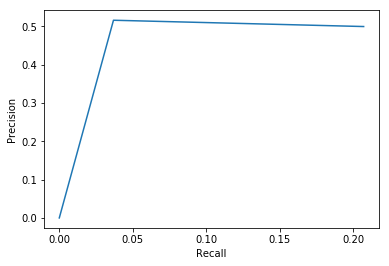


Performance on training set: 

Accuracy = 38.58 %



Performance on test set: 

Accuracy = 40.58 %




In [66]:
eval_attack_net(attack_net, target_model, target_train_loader, target_out_loader, k)

print("\nPerformance on training set: ")
train_accuracy = eval_target_net(target_model, target_train_loader, classes=None)

print("\nPerformance on test set: ")
test_accuracy = eval_target_net(target_model, testloader, classes=None)

Great! At this point, you must have created a succesfful attack model that can detect whether a datapoint was used in training a target mode or not. 
* A successful attack model is one with a precision/recall higher than 85% -- you are using same architecture and are aware of the data classes

 
 Can you suggest any defense mechanism? If yes, Apply them to your solution and re-evaluate your attack model. How did your defense mecanism affect the accuracy of the target model? How did it affect the recall and precision of the Attack model?